In [1]:
import pandas as pd
from IPython.core.display_functions import display
from catboost import CatBoostClassifier
from matplotlib import pyplot as plt
from sklearn import clone
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [2]:
# Create a synthetic dataset
X, y = make_classification(
    n_samples=1000,  # Number of samples
    n_features=10,    # Number of features
    n_informative=2, # Number of informative features
    n_classes=2,     # Number of classes (binary classification)
    n_clusters_per_class=1,  # Number of clusters per class
    random_state=42  # Seed for reproducibility
)

# Create a DataFrame with feature names
feature_names = [f"feature_{i}" for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=feature_names)

# Add the target variable to the DataFrame
df['target'] = y


In [3]:
df.head(2)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,target
0,1.376053,-1.607661,-0.835143,-0.319848,-0.936875,1.603393,0.568754,0.151758,0.184741,2.089539,0
1,-0.005795,1.671348,-0.176134,-0.893746,1.616256,-1.371212,-0.000382,-0.387965,-0.901376,-2.899514,1


In [4]:
train, valid = train_test_split(df, test_size=0.33, random_state=42)

In [15]:
def forward_selection(train, valid, features, cat_features, target):
    stats = []

    picked_features = []
    best_ginis = []
    # forward selection
    for iteration in tqdm(range(len(features))):
        # print('Iteration number', iteration)
        best_gini = None
        best_feature = None
        stat = {'iteration': iteration}
        for col in features:
            if col in picked_features:
                continue

            X_train = train[list(picked_features) + [col]]
            X_valid = valid[list(picked_features) + [col]]

            model = CatBoostClassifier(verbose=0, eval_metric='AUC', early_stopping_rounds=60, random_state=42,
                                       cat_features=list(set(cat_features) & set(X_train.columns)))
            model.fit(X_train, train[target], eval_set=(X_valid, valid[target]))
            valid_preds = model.predict_proba(X_valid)[:, 1]
            valid_gini = 2 * roc_auc_score(valid[target], valid_preds) - 1

            stat[col] = valid_gini

            if best_gini is None or best_gini < valid_gini:
                best_gini = valid_gini
                best_feature = col

        stats.append(stat)

        if best_gini:
            picked_features.append(best_feature)
            best_ginis.append(best_gini)
            print('Picked feature:', best_feature)

    stat_2 = pd.DataFrame(stats).T
    stat_2['cnt_nans'] = stat_2.isna().sum(axis=1).values
    stat_2 = stat_2.sort_values('cnt_nans', ascending=False).drop(columns=['cnt_nans'], index=['iteration'])

    display((stat_2 * 100).round(1))

    stat_1 = pd.DataFrame({'names': picked_features, 'ginis': best_ginis})

    plt.figure(figsize=(16, 9))
    sns.lineplot(data=stat_1, x='names', y='ginis')
    plt.xticks(rotation=90)
    plt.show()

    num_features = stat_1['ginis'].argmax() + 1
    best_gini = stat_1['ginis'].max()
    features_to_eliminate = stat_1['names'].iloc[num_features:]
    best_features = sorted(set(features) - set(features_to_eliminate))

    print('---' * 5, 'info', '---' * 5, sep='')
    print('Best ginis:', best_gini)
    print('Num features:', len(best_features))
    print('Best features:', ' '.join(best_features))
    print('---' * 12)


    return stat_1, stat_2


 10%|█         | 1/10 [00:00<00:05,  1.77it/s]

Picked feature: feature_5


 20%|██        | 2/10 [00:01<00:05,  1.47it/s]

Picked feature: feature_4


 30%|███       | 3/10 [00:01<00:04,  1.68it/s]

Picked feature: feature_8


 40%|████      | 4/10 [00:02<00:03,  1.64it/s]

Picked feature: feature_0


 50%|█████     | 5/10 [00:02<00:02,  1.99it/s]

Picked feature: feature_2


 60%|██████    | 6/10 [00:03<00:02,  1.99it/s]

Picked feature: feature_9


 70%|███████   | 7/10 [00:03<00:01,  2.17it/s]

Picked feature: feature_3


 80%|████████  | 8/10 [00:04<00:00,  2.29it/s]

Picked feature: feature_7


100%|██████████| 10/10 [00:04<00:00,  2.28it/s]

Picked feature: feature_6
Picked feature: feature_1


,0,1,2,3,4,5,6,7,8,9
feature_5,93.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
feature_4,93.0,98.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
feature_8,15.8,92.4,98.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
feature_0,15.3,97.9,98.5,98.5,NaN,NaN,NaN,NaN,NaN,NaN
feature_2,4.2,93.9,98.5,98.4,98.4,NaN,NaN,NaN,NaN,NaN
feature_9,14.2,91.8,98.4,98.4,98.3,98.4,NaN,NaN,NaN,NaN
feature_3,7.1,92.5,98.4,98.2,98.4,98.2,98.5,NaN,NaN,NaN
feature_7,12.2,92.6,98.5,98.4,98.3,98.3,98.3,98.4,NaN,NaN
feature_6,17.8,97.9,98.5,98.5,98.0,98.1,98.2,98.1,98.1,NaN
feature_1,2.5,91.9,98.3,98.2,98.3,98.4,97.9,98.3,98.1,98.4


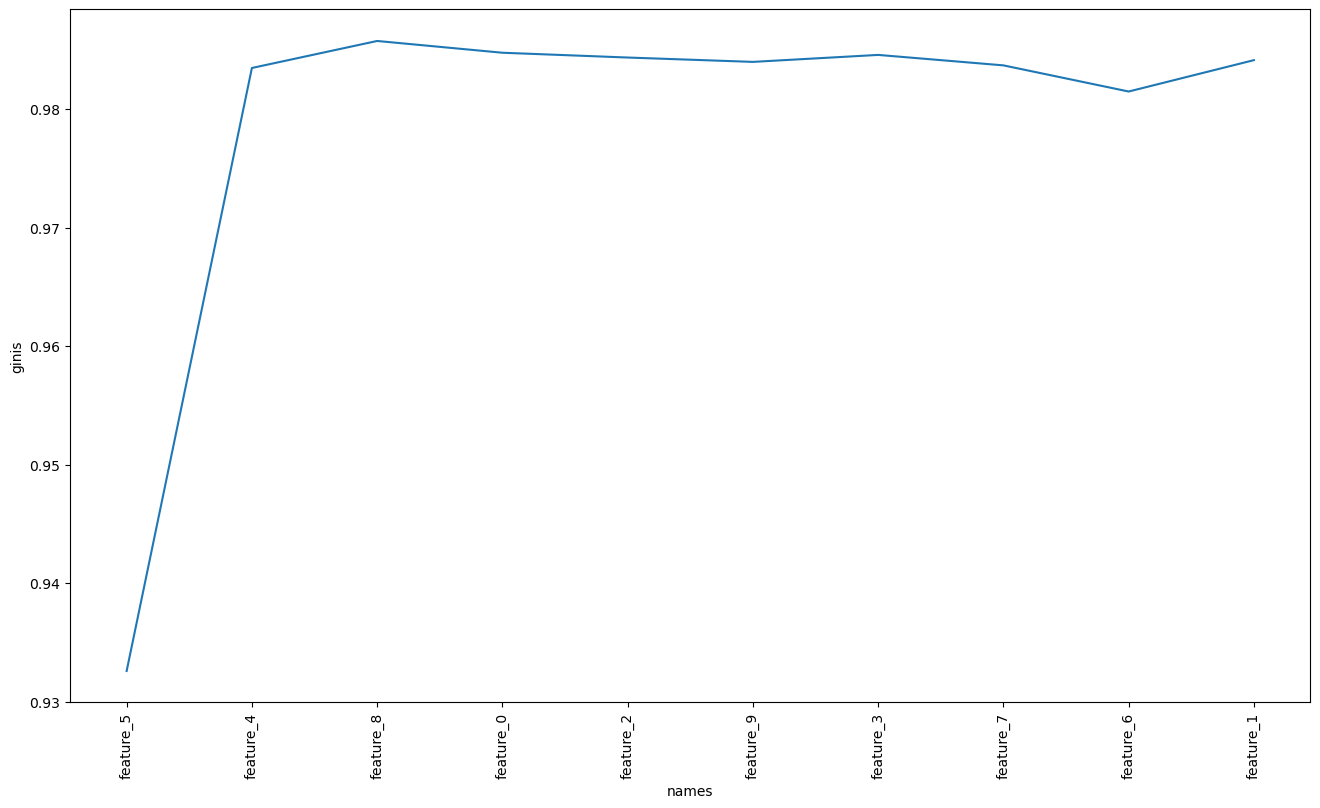

---------------info---------------
Best ginis: 0.9857436801881247
Num features: 3
Best features: feature_4 feature_5 feature_8
------------------------------------


In [16]:
s1, s2 = forward_selection(train,valid, train.columns[:-1], cat_features=[],target='target')